<a href="https://colab.research.google.com/github/mahmud-sayed-alamin/GNN-Water-mark/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(f"Dataset: {dataset.name}")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Edges: {data.num_edges}")
print(f"Number of Features: {data.num_node_features}")
print(f"Number of Classes: {dataset.num_classes}")


Processing...


Dataset: Cora
Number of Nodes: 2708
Number of Edges: 10556
Number of Features: 1433
Number of Classes: 7


Done!


In [5]:
torch.manual_seed(42)

In [6]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.05, training=self.training)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [7]:
model = GCN(
    in_channels=1433,
    hidden_channels=128,
    out_channels=7
)

In [8]:
import torch.nn.functional as F

def compute_loss(output, y, mask):
    loss = F.nll_loss(output[mask], y[mask])
    return loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)

In [9]:
def train(data):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = compute_loss(output, data.y, data.train_mask)
    loss.backward()
    optimizer.step()
    return loss.item()

In [10]:
def test(data):
    model.eval()
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

In [11]:
for epoch in range(260):
    loss = train(data)
    train_acc, val_acc, test_acc = test(data)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 000, Loss: 1.9435, Train Acc: 0.8429, Val Acc: 0.5400, Test Acc: 0.5970
Epoch: 010, Loss: 0.8945, Train Acc: 0.9643, Val Acc: 0.7600, Test Acc: 0.7990
Epoch: 020, Loss: 0.6689, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8160
Epoch: 030, Loss: 0.6960, Train Acc: 0.9857, Val Acc: 0.7880, Test Acc: 0.8110
Epoch: 040, Loss: 0.7475, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8060
Epoch: 050, Loss: 0.7380, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8110
Epoch: 060, Loss: 0.7220, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8110
Epoch: 070, Loss: 0.7277, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8110
Epoch: 080, Loss: 0.7244, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8100
Epoch: 090, Loss: 0.7239, Train Acc: 0.9714, Val Acc: 0.7820, Test Acc: 0.8110
Epoch: 100, Loss: 0.7191, Train Acc: 0.9714, Val Acc: 0.7840, Test Acc: 0.8110
Epoch: 110, Loss: 0.7223, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8110
Epoch: 120, Loss: 0.7206, Train Acc: 0.9786, Val Acc

In [12]:
def evaluate(data):
    model.eval()

    with torch.no_grad():
        output = model(data.x, data.edge_index)

    predictions = output.argmax(dim=1)

    accuracies = {}
    for mask_name, mask in [('Train', data.train_mask),
                            ('Validation', data.val_mask),
                            ('Test', data.test_mask)]:
        correct = predictions[mask].eq(data.y[mask]).sum().item()
        total = mask.sum().item()
        accuracy = correct / total
        accuracies[mask_name] = accuracy

    return accuracies

In [13]:
train_acc_list = []
val_acc_list = []
loss_list = []

for epoch in range(200):
    loss = train(data)
    loss_list.append(loss)

    accuracies = evaluate(data)
    train_acc_list.append(accuracies['Train'])
    val_acc_list.append(accuracies['Validation'])

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {accuracies['Train']:.4f}, "
              f"Val Acc: {accuracies['Validation']:.4f}, "
              f"Test Acc: {accuracies['Test']:.4f}")



Epoch 000, Loss: 0.7261, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8150
Epoch 010, Loss: 0.7195, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8120
Epoch 020, Loss: 0.7177, Train Acc: 0.9857, Val Acc: 0.7840, Test Acc: 0.8160
Epoch 030, Loss: 0.7146, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8150
Epoch 040, Loss: 0.7207, Train Acc: 0.9857, Val Acc: 0.7800, Test Acc: 0.8140
Epoch 050, Loss: 0.7153, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8130
Epoch 060, Loss: 0.7133, Train Acc: 0.9857, Val Acc: 0.7820, Test Acc: 0.8130
Epoch 070, Loss: 0.7214, Train Acc: 0.9857, Val Acc: 0.7800, Test Acc: 0.8110
Epoch 080, Loss: 0.7206, Train Acc: 0.9714, Val Acc: 0.7820, Test Acc: 0.8130
Epoch 090, Loss: 0.7170, Train Acc: 0.9786, Val Acc: 0.7780, Test Acc: 0.8120
Epoch 100, Loss: 0.7120, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8140
Epoch 110, Loss: 0.7169, Train Acc: 0.9786, Val Acc: 0.7860, Test Acc: 0.8170
Epoch 120, Loss: 0.7231, Train Acc: 0.9786, Val Acc: 0.7780, Tes

In [15]:
def generate_trigger_graph(data, model, num_trigger_nodes=10, target_label=0):
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        predictions = output.argmax(dim=1)

    target_nodes = torch.where(predictions == target_label)[0][:num_trigger_nodes]

    trigger_features = data.x[target_nodes].clone()

    num_original_nodes = data.x.shape[0]

    trigger_indices = torch.arange(num_original_nodes, num_original_nodes + num_trigger_nodes)

    new_edges = torch.cat([
        torch.stack([trigger_indices, target_nodes], dim=0),
        torch.stack([target_nodes, trigger_indices], dim=0)
    ], dim=1)

    return {
        'features': trigger_features,
        'edges': new_edges,
        'nodes': trigger_indices
    }

In [16]:
def train_with_watermark(data, trigger_graph, target_label):
    model.train()
    optimizer.zero_grad()

    # Combine clean graph with trigger graph
    x_combined = torch.cat([data.x, trigger_graph['features']], dim=0)
    edge_index_combined = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)

    output = model(x_combined, edge_index_combined)

    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])

    trigger_loss = F.nll_loss(output[trigger_graph['nodes']], target_label)
    total_loss = loss + trigger_loss

    total_loss.backward()
    optimizer.step()
    trigger_graph
    return total_loss.item()

In [17]:
def verify_ownership(model, data, trigger_graph, target_label):
    model.eval()

    # Combine original data with trigger graph
    x_combined = torch.cat([data.x, trigger_graph['features']], dim=0)
    edge_index_combined = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)

    with torch.no_grad():
        output = model(x_combined, edge_index_combined)

    predictions = output[trigger_graph['nodes']].argmax(dim=1)

    trigger_accuracy = (predictions == target_label).sum().item() / len(trigger_graph['nodes'])

    return trigger_accuracy

In [18]:
def create_new_data(data, trigger_graph):
    num_original_nodes = data.x.shape[0]

    new_x = torch.cat([data.x, trigger_graph['features']], dim=0)

    new_edge_index = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)

    new_y = torch.cat([data.y, torch.full((trigger_graph['nodes'].shape[0],), -1, dtype=torch.long)])

    # Extend masks
    new_train_mask = torch.cat([data.train_mask, torch.zeros(trigger_graph['nodes'].shape[0], dtype=torch.bool)])
    new_val_mask = torch.cat([data.val_mask, torch.zeros(trigger_graph['nodes'].shape[0], dtype=torch.bool)])
    new_test_mask = torch.cat([data.test_mask, torch.zeros(trigger_graph['nodes'].shape[0], dtype=torch.bool)])

    new_data = data.__class__(
        x=new_x,
        edge_index=new_edge_index,
        y=new_y,
        train_mask=new_train_mask,
        val_mask=new_val_mask,
        test_mask=new_test_mask
    )

    return new_data

trigger_graph = generate_trigger_graph(data, model)

new_data = create_new_data(data, trigger_graph)


In [19]:
# Evaluate Fidelity
original_model_performance = evaluate(data)
print(f"Train Acc: {original_model_performance['Train']}, Test Acc: {original_model_performance['Test']}")

watermarked_model_performance = evaluate(new_data)
print(f"Train Acc: {watermarked_model_performance['Train']}, Test Acc: {watermarked_model_performance['Test']}")

# Evaluate Watermark Effectiveness
trigger_graph = generate_trigger_graph(data, model)
trigger_accuracy = verify_ownership(model, data, trigger_graph, target_label=0)
print(f"Watermark Accuracy: {trigger_accuracy * 100:.2f}%")

Train Acc: 0.9785714285714285, Test Acc: 0.817
Train Acc: 0.9857142857142858, Test Acc: 0.816
Watermark Accuracy: 80.00%


In [27]:
from sklearn.metrics import f1_score

output = model(data.x, data.edge_index)
pred = output.argmax(dim=1)

y_true = data.y[data.test_mask].cpu().numpy()
y_pred = pred[data.test_mask].cpu().numpy()

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.8190772867404816


In [33]:
from sklearn.metrics import f1_score

output = model(new_data.x, new_data.edge_index)
pred = output.argmax(dim=1)

y_true = new_data.y[new_data.test_mask].cpu().numpy()
y_pred = pred[new_data.test_mask].cpu().numpy()

# Calculate F1 score
f1_triggered = f1_score(y_true, y_pred, average='weighted')
print(f'f1_triggered Score: {f1_triggered}')

f1_triggered Score: 0.8182140124865925


In [45]:
paper_results = {
    "Metric": ["Watermark accuracy"],
    "Paper verification performance": [99.00],
}

verification_performance = trigger_accuracy*100

results = {
    "Metric": ["Watermark accuracy"],
    "verification_performance": [verification_performance]
}

comparison_df = pd.DataFrame(paper_results).set_index("Metric")
comparison_df[["Verification performance"]] = pd.DataFrame(results).set_index("Metric")

print("\nComparison Table (GCN on Cora)\n")
print(comparison_df.to_markdown())


Comparison Table (GCN on Cora)

| Metric             |   Paper verification performance |   Verification performance |
|:-------------------|---------------------------------:|---------------------------:|
| Watermark accuracy |                               99 |                         80 |


In [46]:
import pandas as pd

# Paper results for GCN on Cora
paper_results = {
    "Metric": ["Accuracy", "F1-Score"],
    "Paper Original": [83.74, 83.70],
    "Paper Watermarked": [83.40, 83.70]
}

model_accuracy_original = original_model_performance['Test']*100
model_accuracy_watermarked = watermarked_model_performance['Test']*100
verification_performance = trigger_accuracy*100

model_f1_original = f1*100
model_f1_watermarked = f1_triggered*100

results = {
    "Metric": ["Accuracy", "F1-Score"],
    "Original": [model_accuracy_original, model_f1_original],
    "Watermarked": [model_accuracy_watermarked, model_f1_watermarked],
}

comparison_df = pd.DataFrame(paper_results).set_index("Metric")
comparison_df[["Original", "Watermarked"]] = pd.DataFrame(results).set_index("Metric")

print("\nComparison Table (GCN on Cora)\n")
print(comparison_df.to_markdown())


Comparison Table (GCN on Cora)

| Metric   |   Paper Original |   Paper Watermarked |   Original |   Watermarked |
|:---------|-----------------:|--------------------:|-----------:|--------------:|
| Accuracy |            83.74 |                83.4 |    81.7    |       81.6    |
| F1-Score |            83.7  |                83.7 |    81.9077 |       81.8214 |


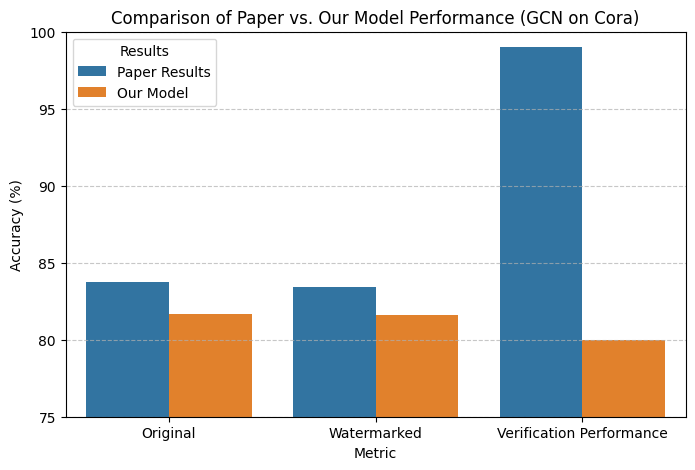

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Original", "Watermarked", "Verification Performance"]
paper_values = [83.74, 83.40, 99.00]
model_values = [model_accuracy_original, model_accuracy_watermarked, verification_performance]

df = pd.DataFrame({
    "Metric": metrics,
    "Paper Results": paper_values,
    "Our Model": model_values
})

plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Metric", y="value", hue="variable", data=df.melt(id_vars=["Metric"], var_name="variable"))
plt.xlabel("Metric")
plt.ylabel("Accuracy (%)")
plt.title("Comparison of Paper vs. Our Model Performance (GCN on Cora)")
plt.ylim(75, 100)
plt.legend(title="Results")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
